### 1. Import the Necessary Packages

In [3]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

## Define Policy

In [37]:
class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):

        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.fc1.weight.device)
        probs = self(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

## Run Episodes (One episode a time not batch)

In [45]:

def run_episode(policy, env, max_t):
    saved_log_probs = []
    rewards = []
    state = env.reset()
    for t in range(max_t):
        action, log_prob = policy.act(state)
        saved_log_probs.append(log_prob)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break 
    return rewards, saved_log_probs

def reinforce(policy, env, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    optimizer = optim.Adam(policy.parameters(), lr=1e-2)
    
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        rewards, saved_log_probs = run_episode(policy, env, max_t)
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = gamma ** np.arange(len(rewards))
        R = np.sum(discounts * rewards)
        
        log_rewards = [-log_prob * R for log_prob in saved_log_probs]
        policy_loss = torch.cat(log_rewards).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
env = gym.make('CartPole-v0')
env.seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)
policy = Policy().to(device)

scores = reinforce(policy, env)

Episode 100	Average Score: 34.47
Episode 200	Average Score: 66.26
Episode 300	Average Score: 87.82
Episode 400	Average Score: 72.83
Episode 500	Average Score: 172.00
Episode 600	Average Score: 160.65
Episode 700	Average Score: 167.15
Environment solved in 691 episodes!	Average Score: 196.69


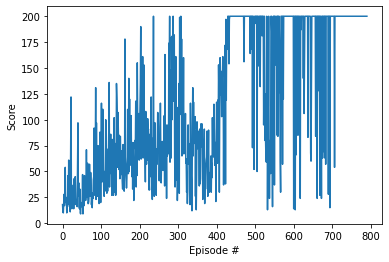

In [46]:
import matplotlib.pyplot as plt

plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [47]:
env = gym.make('CartPole-v0')

state = env.reset()
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()